# hopfiled神经网络及其实现  
小组成员：沈旭阳、谭力仁、温紫珺、邹子涵  
汇报成员：沈旭阳

## 实验介绍  
实验类别：hopfile神经网络；离散型；异步更新  
Hopfield神经网络是一种非常典型的反馈型神经网络，除了与前馈神经系统相同的神经元之间的前馈连接，很明显还存在一种反馈连接。  
Hopfield网络结构可以用以下示意图描述：

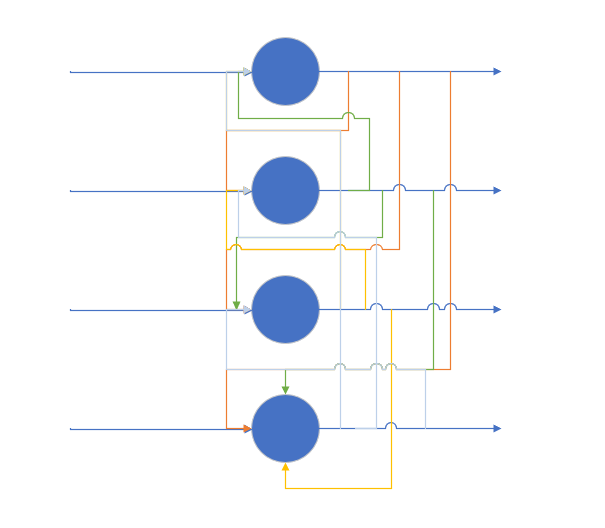

从示意图中可知，该神经网络结构具有以下三个特点：  
  
1、神经元之间全连接，并且为单层神经网络。  
2、每个神经元既是输入又是输出，导致得到的权重矩阵相对称，故可节约计算量。  
3、在输入的激励下，其输出会产生不断的状态变化，这个反馈过程会一直反复进行。假如Hopfield神经网络是一个收敛的稳定网络，则这个反馈与迭代的计算过程所产生的变化越来越小，一旦达到了稳定的平衡状态，Hopfield网络就会输出一个稳定的恒值。  
4、Hopfield网络可以储存一组平衡点，使得当给定网络一组初始状态时，网络通过自行运行而最终收敛于这个设计的平衡点上。当然，根据热力学上，平衡状态分为stable state和metastable state, 这两种状态在网络的收敛过程中都是非常可能的。  
5、为递归型网络，t时刻的状态与t-1时刻的输出状态有关。之后的神经元更新过程也采用的是异步更新法（Asynchronous)。  

## python实现

### 导包

In [1]:
import numpy as np
import random
from PIL import Image
import os
import re
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 将图片转换为二值矩阵  
函数参数为（file、size、threshold）  
分别代表（图片文件、图片大小、2值化阈值）

In [2]:
def readImg2array(file,size, threshold= 145):
    pilIN = Image.open(file).convert(mode="L")
    pilIN= pilIN.resize(size)
    imgArray = np.asarray(pilIN,dtype=np.uint8)
    x = np.zeros(imgArray.shape,dtype=np.float)
    x[imgArray > threshold] = 1
    x[x==0] = -1
    return x

### 二值矩阵转化为图片  
函数参数为（矩阵、输出文件）  
输出文件默认为空

In [3]:
def array2img(data, outFile = None):
    y = np.zeros(data.shape,dtype=np.uint8)
    y[data==1] = 255
    y[data==-1] = 0
    img = Image.fromarray(y,mode="L")
    if outFile is not None:
        img.save(outFile)
    return img

### 将矩阵转换为向量形式

In [4]:
def mat2vec(x):
    m = x.shape[0]*x.shape[1]
    tmp1 = np.zeros(m)

    c = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            tmp1[c] = x[i,j]
            c +=1
    return tmp1

### 创建Hij即权重矩阵，依据hopfile特性，该矩阵为对称矩阵

In [5]:
def create_W_single_pattern(x):
    if len(x.shape) != 1:
        print ("该输入不是一个向量！")
        return
    else:
        w = np.zeros([len(x),len(x)])
        for i in range(len(x)):
            for j in range(i,len(x)):
                if i == j:
                    w[i,j] = 0
                else:
                    w[i,j] = x[i]*x[j]
#                     对称矩阵性质
                    w[j,i] = w[i,j]
    return w

### 建立hopfiled升级函数对神经元随机升级，采用异步更新，获取更新后的神经元向量以及系统能量。

In [6]:
def update_asynch(weight,vector,theta=0.5,times=100):
#     初始化参数
    energy_ = []
    times_ = []
#     记录系统能量更新过程
    energy_.append(energy(weight,vector))
#     记录迭代次数
    times_.append(0)
#     遍历迭代次数
    for i in range(times):
#         获取随机数，对随机神经元进行更新
        length = len(vector)
        update_num = random.randint(0,length-1)
#         对神经元更新
        next_time_value = np.dot(weight[update_num][:],vector) - theta
#         sign激活函数，对更新值取符号
        if next_time_value>=0:
            vector[update_num] = 1
        if next_time_value<0:
            vector[update_num] = -1
#         记录迭代次数和系统能量变化
        times_.append(i)
        energy_.append(energy(weight,vector))
    
    return (vector,times_,energy_)

### 计算系统能量

In [7]:
def energy(weight,x,bias=0):
    energy = -x.dot(weight).dot(x.T)+sum(bias*x)
    return energy

## hopfiled主体实现

Text(0.5,1,'training picture')

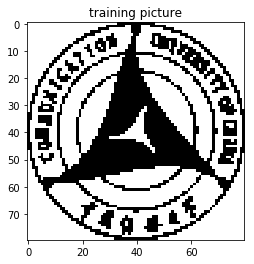

(6400, 6400)
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


In [8]:
size_global =(80,80)
threshold_global = 220

train_paths = []
train_path = "./training/"
for i in os.listdir(train_path):
    if re.match(r'[0-9 a-z A-Z-_]*.jp[e]*g',i):
        train_paths.append(train_path+i)
flag = 0
for path in train_paths:
    matrix_train = readImg2array(path,size = size_global,threshold=threshold_global)
    vector_train = mat2vec(matrix_train)
    plt.imshow(array2img(matrix_train))
    plt.title("training picture")
    plt.show()
    if flag == 0:
        w_ = create_W_single_pattern(vector_train)
        flag = flag +1
    else:
        w_ = w_ +create_W_single_pattern(vector_train)
        flag = flag +1

# 建立权值矩阵
w_ = w_/flag
print(w_.shape)
print(w_)

Text(0.5,1,'test picture')

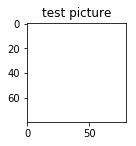

In [9]:
test_paths = []
test_path = "./test/"
for i in os.listdir(test_path):
    if re.match(r'[0-9 a-z A-Z-_]*.jp[e]*g',i):
        test_paths.append(test_path+i)
num = 0
for path in test_paths:
    num = num+1
    matrix_test = readImg2array(path,size = size_global,threshold=threshold_global)
    vector_test = mat2vec(matrix_test)
    plt.subplot(221)
    plt.imshow(array2img(matrix_test))
    plt.title("test picture")

Text(0.5,1,'recall1')

Text(0,0.5,'energy')

Text(0.5,0,'update times')

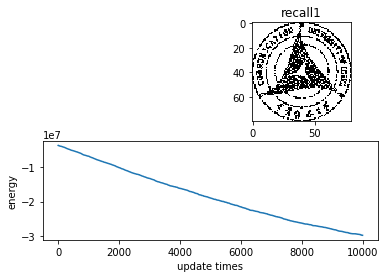

In [10]:
oshape = matrix_test.shape
aa = update_asynch(weight=w_,vector=vector_test,theta = 0.5 ,times=10000)
vector_test_update = aa[0]
matrix_test_update = vector_test_update.reshape(oshape)
plt.subplot(222)
plt.imshow(array2img(matrix_test_update))
plt.title("recall"+str(num))

#plt.show()
plt.subplot(212)
plt.plot(aa[1],aa[2])
plt.ylabel("energy")
plt.xlabel("update times")

plt.show()